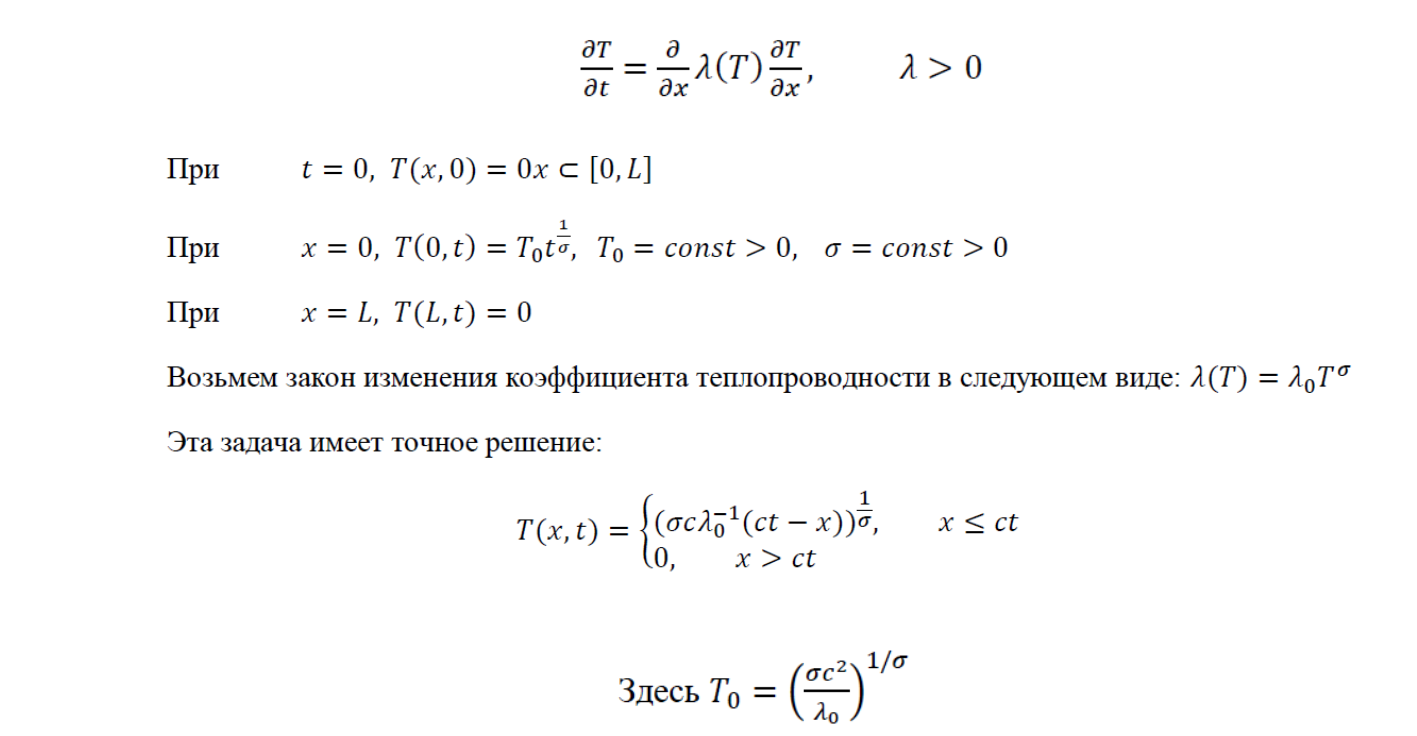

In [13]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from matplotlib import animation

In [120]:
L = 2.
h = 0.05
tau = 0.0002
lam0 = 0.5
sigma = 2.
c = 1.0
u0 = ( sigma * c ** 2 / lam0 ) ** ( 1. / sigma )
gamma = 0.5 + h ** 2 / ( 12. * lam0 * tau )

x = np.arange( 0, L, h )
U0 = np.zeros( x.size ) + 0.0001


In [121]:
@njit
def Lam( u ): # lambda( u ) = lambda_0 * u^k

    global sigma, lam0

    return lam0 * u ** sigma

In [122]:
@njit
def LamFun( uPlus, uMinus ): # lambda_+/- = ( lambda_m + lambda_{m+1/m-1} ) / 2.

    global Lam

    LamPlus = Lam( uPlus )

    LamMinus = Lam( uMinus )

    return ( LamPlus + LamMinus ) / 2.

In [123]:
@njit
def Approx( u, m ):

    global LamFun
    global h

    LamPlus = LamFun( u[ m + 1 ], u[ m ] )

    LamMinus = LamFun( u[ m ], u[ m - 1 ] )

    return ( LamPlus * ( u[ m + 1 ] - u[ m ] ) - LamMinus * ( u[ m ] - u[ m - 1 ] ) ) / h ** 2


In [124]:
@njit
def A( u, m ):

    global h, gamma, tau
    global LamFun

    return gamma * tau * LamFun( u[ m ], u[ m - 1 ] ) / h ** 2

@njit
def B( u, m ):

    global h, gamma, tau
    global LamFun

    LamPlus = LamFun( u[ m ], u[ m + 1 ] )

    LamMinus = LamFun( u[ m ], u[ m - 1 ] )

    return -gamma * tau * ( LamPlus + LamMinus ) / h ** 2 - 1.

@njit
def C( u, m ):

    global h, gamma, tau
    global LamFun

    return gamma * tau * LamFun( u[ m ], u[ m + 1 ] ) / h ** 2

@njit
def D( u, m ):

    global h, gamma, tau
    global LamFun, Approx

    return u[ m ] + tau * ( 1. - gamma ) * Approx( u, m )

In [125]:
@njit
def Matrix( u ):

    global A, B, C

    Mat = np.zeros( ( u.size, u.size ) )

    Mat[ 0 ][ 0 ] = 1

    for m in np.arange( 1, u.size-1, 1 ):

        Mat[ m ][ m - 1 ] = A( u, m )

        Mat[ m ][ m ] = B( u, m )

        Mat[ m ][ m + 1 ] = C( u, m )

    Mat[-1][-1] = 1.

    return Mat

In [126]:
@njit
def vecD( u ):

    global D

    f = np.copy( u )

    for k in np.arange( 1, u.size-1, 1 ):

        f[ k ] = -D( u, k )

    return f

In [127]:
#Шеститочечный метод
@njit
def SixPointsMth( u, T ):
    
    global h, tau, gamma, u0

    global Matrix, vecD

    uNew = np.copy(u)

    M = int( T / tau )

    for i in np.arange( 0, M, 1 ):

        t = i * tau

        uNew[ 0 ] = u0 * t ** (1. / sigma)

        uNew[ -1 ] = 0.0

        uNew = np.linalg.solve( Matrix( uNew ), vecD( uNew ) )

    return uNew

#Явная схема
@njit
def Evid( u, T ):

    global h, tau, gamma, u0
    global Approx

    uNew = np.copy( u )

    uOld = np.copy( u )

    M = int( T / tau )

    for i in np.arange( 0, M, 1 ):

        uNew[ 0 ] = u0 * ( i * tau ) ** (1. / sigma)

        uNew[ -1 ] = 0.0

        for j in np.arange( 1, u.size - 1, 1 ):

            uNew[ j ] = uOld[ j ] + tau * Approx( uOld, j )

        uOld = uNew

    return uNew

@njit
def Toch( x, T ):

    global c, sigma, h, lam0

    u = np.zeros( x.size )

    for m in np.arange( 0, u.size, 1 ):

        if m * h > c * T:

            u[ m ] = 0.0

        else:

            u[ m ] = ( sigma * c * ( c * T - m * h ) / lam0 ) ** ( 1. / sigma )

    return u

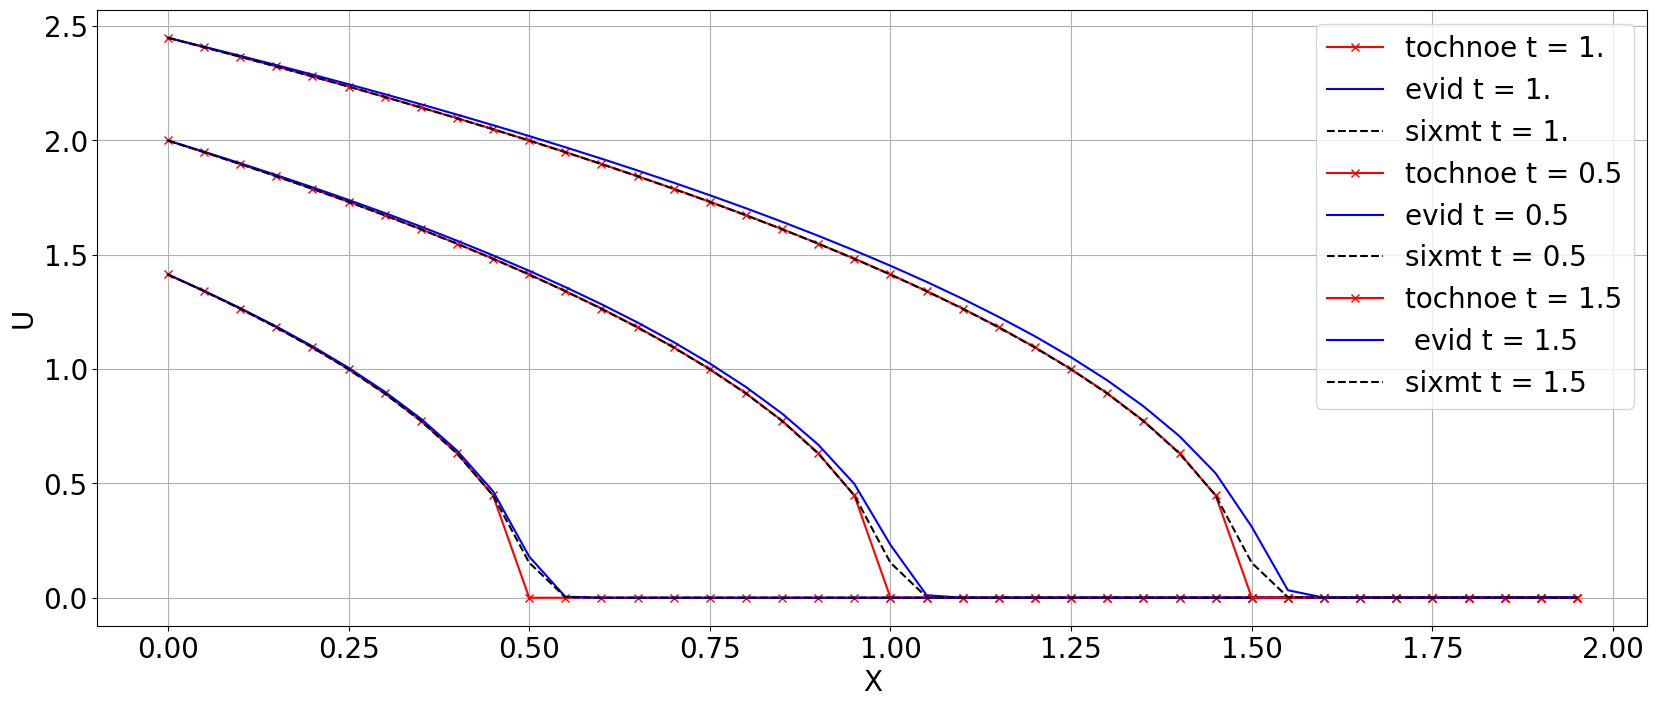

In [128]:
u11 = Toch( U0, 1. )
u12 = Evid( U0, 1. )
u13 = SixPointsMth( U0, 1 )

u21 = Toch( U0, .5 )
u22 = Evid( U0, .5 )
u23 = SixPointsMth( U0, 0.5 )

u31 = Toch( U0, 1.5 )
u32 = Evid( U0, 1.5 )
u33 = SixPointsMth( U0, 1.5 )

plt.figure( figsize = ( 20, 8 ) )
plt.rc('font', **{'size' : 20})
plt.grid()
plt.xlabel( 'X' )
plt.ylabel( 'U' )
plt.plot( x, u11, 'r-x',
          x, u12, 'b-',
          x, u13, 'k--')

plt.plot( x, u21, 'r-x',
          x, u22, 'b-',
          x, u23, 'k--')

plt.plot( x, u31, 'r-x',
          x, u32, 'b-',
          x, u33, 'k--')

plt.legend( [ 'tochnoe t = 1.', 'evid t = 1.', 'sixmt t = 1.',
              'tochnoe t = 0.5', 'evid t = 0.5', 'sixmt t = 0.5',
              'tochnoe t = 1.5',' evid t = 1.5', 'sixmt t = 1.5' ] )
plt.show()